In [1]:
import caffe

In [2]:
pwd

u'/data/convchess/src/play/example_moves'

In [3]:
cd /data/convchess/src/play/example_moves/

/data/convchess/src/play/example_moves


In [4]:
cd ..

/data/convchess/src/play


In [5]:
ls

example_moves/  play4.py                 sunfish/          sunfish.py
__init__.py     play4.pyc                sunfish_mod2.py   sunfish.pyc
__init__.pyc    play_against_sunfish.py  sunfish_mod2.pyc  sync_models.sh*
models/         play.py                  sunfish_mod3.py   td_evaluate.py
play2.py        play.pyc                 sunfish_mod3.pyc  td_evaluate.pyc
play2.pyc       regression_models@       sunfish_mod4.py   util.py
play3.py        sample.svg               sunfish_mod.py    util.pyc
play3.pyc       stats.txt                sunfish_mod.pyc   win.txt


In [6]:
from play4 import *

In [7]:
trained_models

{'B': <caffe._caffe.Net at 0x7f8f947c9310>,
 'K': <caffe._caffe.Net at 0x7f8f947c93c0>,
 'N': <caffe._caffe.Net at 0x7f8f947c92b8>,
 'P': <caffe._caffe.Net at 0x7f8f947c9208>,
 'Piece': <caffe._caffe.Net at 0x7f8f947b9e10>,
 'Q': <caffe._caffe.Net at 0x7f8f947c9368>,
 'R': <caffe._caffe.Net at 0x7f8f947c9260>}

In [8]:
pos = sunfish.Position(sunfish.initial, 0, (True,True), (True,True), 0, 0)
print pos.board
bb = pos_board_to_bitboard(pos.board)
print bb
#since the models have an elo layer for a 12 channel style, we will add that too.
im = convert_bitboard_to_image_2(bb)
im = np.rollaxis(im ,2 , 0)
im = np.append(im, elo_layer, axis=0)
print im

         
         
 rnbqkbnr
 pppppppp
 ........
 ........
 ........
 ........
 PPPPPPPP
 RNBQKBNR
         
          
r n b q k b n r 
p p p p p p p p 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
P P P P P P P P 
R N B Q K B N R
[[[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  

In [9]:
get_top_moves(im, 20)

[('e2e4', 0.60884749889373779),
 ('d2d4', 0.24676373600959778),
 ('c2c4', 0.072589606046676636),
 ('g1f3', 0.03345726802945137),
 ('e2e3', 0.017165167257189751),
 ('f2f4', 0.005938130896538496),
 ('g2g3', 0.0052636517211794853),
 ('b1c3', 0.0021147150546312332),
 ('b2b3', 0.0013837352162227035),
 ('c2c3', 0.0013727180194109678),
 ('a2a4', 0.0011852135648950934),
 ('g2g4', 0.00085490604396909475),
 ('h2h3', 0.00077917467569932342),
 ('b2b4', 0.00070094328839331865),
 ('a2a3', 0.00052395882084965706),
 ('g1h3', 0.00027808721642941236),
 ('b1a3', 0.00027160250465385616),
 ('h2h4', 0.00020872396999038756),
 ('d2d3', 0.00020706524082925171),
 ('f2f3', 3.1040624890010804e-05)]

In [10]:
dummy = np.ones((1,), dtype=np.float32)
net = trained_models['Piece']
net.set_input_arrays(np.array([im], dtype='float32'),dummy)
res = net.forward()
probs = res['prob']
matrix= probs.reshape((8,8))

#matrix = (matrix+matrix[:,::-1])/2.0

In [11]:
net.blobs['fc1'].data

array([[ -2.98251152,  -5.51878643,  -2.99327874,  -2.8657515 ,
         -3.63778591,  -4.15594721,  -4.13724089,  -3.50645518,
          0.43081114,   1.32339585,   1.75646389,  -1.99681902,
         -1.62481666,   2.05074   ,   1.96704984,   0.90310532,
         -0.0738112 ,  -0.29265645,   1.61630344,   1.32374632,
          1.73880315,   1.72373831,   1.71312559,   0.71323323,
         -3.90485859,  -5.77646637,  -3.52694654,  -5.63183498,
         -3.42693162,  -2.36830974,  -3.80674434,  -1.9355315 ,
         -4.49059629,  -3.58955121,  -8.51823997,  -7.25169945,
         -5.93174839,  -7.23025322,  -3.84461713,  -4.57049036,
         -1.78072977,  -4.48415613,  -3.72528243,  -2.61909199,
         -0.84338367,  -5.13836193,  -6.23589945,  -3.02789569,
          8.90192509,   9.10053062,  12.66947174,  13.87518597,
         14.80528641,  10.15252399,  10.17724228,   8.35374069,
          1.58959222,   9.23566723,   4.26568031,   4.58815527,
          2.64974356,   3.35970879,  11.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
plt.rc('text', usetex=False, antialiased=True, hinting='auto', dvipnghack=True)
plt.rc('font', family='serif', size=12)
def matrixplot(c_matrix):
    ax = plt.imshow(c_matrix, interpolation='nearest', cmap=cm.Blues ,
        extent=(0,np.shape(matrix)[0],0.5,np.shape(matrix)[1]+0.5))
    plt.xticks(range(8), string.lowercase)
    ax.set_extent([-0.5,7.5,0.5,8.5])
    plt.colorbar(ax)
    plt.show()

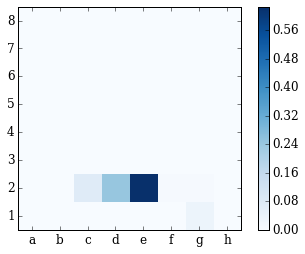

In [13]:
matrixplot(matrix)

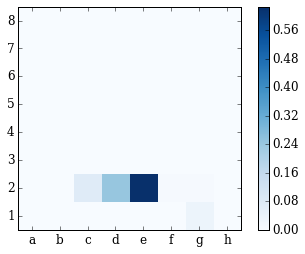

In [14]:
c_probs = clip_pieces_single_2(probs, im[0:12])
c_matrix = c_probs.reshape((8,8))
#c_matrix = (c_matrix+c_matrix[:,::-1])/2.0
matrixplot(c_matrix)

In [15]:
dummy = np.ones((1,), dtype='float32')
net = trained_models['Piece']
net.set_input_arrays(np.array([im], dtype=np.float32),dummy)
res = net.forward()
probs = res['prob']
#probs = clip_pieces_single_2(probs, im[0:12])
#print probs
probs = probs.flatten()
cumulative_probs = np.zeros((64,64))    
for i, piece_pos in enumerate(topk(probs,10)):
    if probs[piece_pos]>0:
        i1,i2 = scoreToCoordinateIndex(piece_pos)
        pieceType = INDEX_TO_PIECE[np.argmax(im[0:12, i1, i2])/2]
        piece_layer = np.zeros((1,8,8))
        piece_layer[0,i1,i2] = 1
        img2 = np.append(im, piece_layer, axis=0)
        model = trained_models[pieceType]
        model.set_input_arrays(np.array([img2], dtype=np.float32),dummy)
        res2 = model.forward()
        move_prob = res2['prob']
        #print move_prob
        #move_prob = clip_moves_2(move_prob, img2[0:12], (i1,i2))
        #print move_prob
        cumulative_probs[piece_pos] = move_prob*probs[piece_pos]

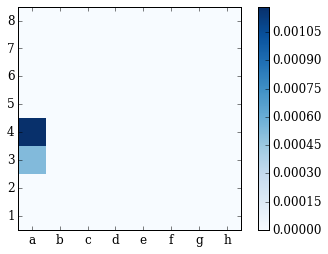

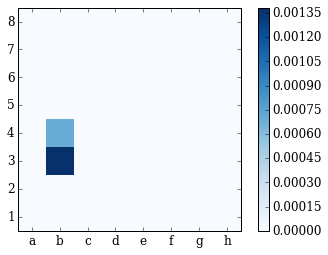

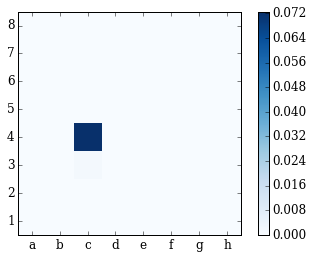

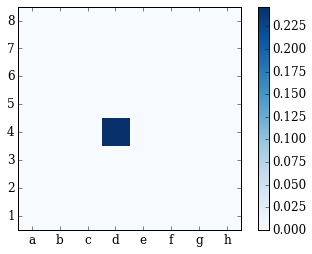

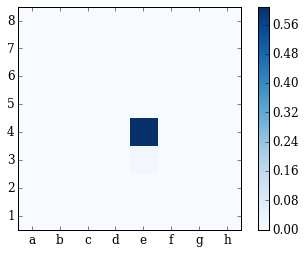

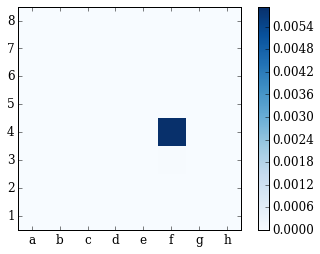

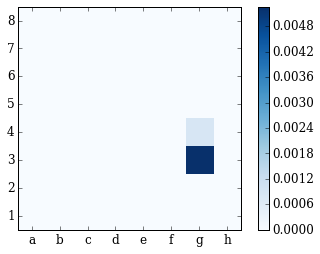

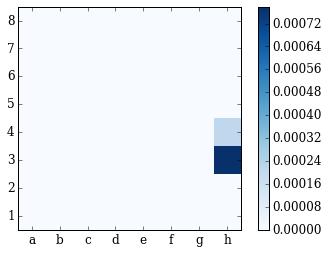

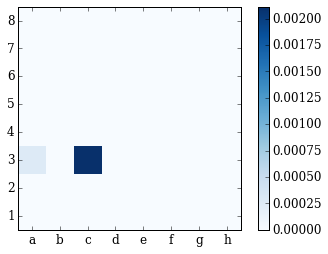

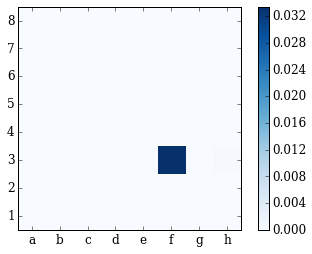

In [16]:
matrixplot(cumulative_probs[48].reshape((8,8)))
matrixplot(cumulative_probs[49].reshape((8,8)))
matrixplot(cumulative_probs[50].reshape((8,8)))
matrixplot(cumulative_probs[51].reshape((8,8)))
matrixplot(cumulative_probs[52].reshape((8,8)))
matrixplot(cumulative_probs[53].reshape((8,8)))
matrixplot(cumulative_probs[54].reshape((8,8)))
matrixplot(cumulative_probs[55].reshape((8,8)))
matrixplot(cumulative_probs[57].reshape((8,8)))
matrixplot(cumulative_probs[62].reshape((8,8)))


In [17]:
cd example_moves/draw_board/

/data/convchess/src/util/draw_board


In [18]:
import numpy as np
import cv2
pieces = ['pawn', 'rook', 'knight', 'bishop', 'queen', 'king']

def blank_board(img_size):
	board = np.zeros((img_size, img_size), dtype=np.uint8)
	piece_size = img_size/8
	for i in xrange(8):
		for j in xrange(8):
			if (i+j)%2 == 0:
				board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size] = 255*np.ones((piece_size, piece_size), dtype=np.uint8)
	return board

def draw_board(bitmap, img_size=344, highlight=None):
	piece_size = img_size/8

	#initialize blank board
	board = blank_board(img_size)
	bw = cv2.CV_LOAD_IMAGE_GRAYSCALE
	#load piece images
	wpawnw = cv2.imread("elements/wpawnw.png", bw)
	wpawnb = cv2.imread("elements/wpawnb.png", bw)
	bpawnw = abs(255-wpawnb)
	bpawnb = abs(255-wpawnw)
	wrookw = cv2.imread("elements/wrookw.png", bw)
	wrookb = cv2.imread("elements/wrookb.png", bw)
	brookw = abs(255-wrookb)
	brookb = abs(255-wrookw)
	wknightw = cv2.imread("elements/wknightw.png", bw)
	wknightb = cv2.imread("elements/wknightb.png", bw)
	bknightw = abs(255-wknightb)
	bknightb = abs(255-wknightw)
	wbishopw = cv2.imread("elements/wbishopw.png", bw)
	wbishopb = cv2.imread("elements/wbishopb.png", bw)
	bbishopw = abs(255-wbishopb)
	bbishopb = abs(255-wbishopw)
	wqueenw = cv2.imread("elements/wqueenw.png", bw)
	wqueenb = cv2.imread("elements/wqueenb.png", bw)
	bqueenw = abs(255-wqueenb)
	bqueenb = abs(255-wqueenw)
	wkingw = cv2.imread("elements/wkingw.png", bw)
	wkingb = cv2.imread("elements/wkingb.png", bw)
	bkingw = abs(255-wkingb)
	bkingb = abs(255-wkingw)

	for p in xrange(bitmap.shape[0]-1):
		for i in xrange(bitmap.shape[1]):
			for j in xrange(bitmap.shape[2]):
				if p%2==0 and bitmap[p,i,j] == 1:
					piece = "w"
				elif p%2==1 and bitmap[p,i,j] == 1:
					piece = "b"
				else:
					continue
				piece = piece+pieces[p/2]
				if (i+j)%2 == 0:
					piece = piece+"w"
				else:
					piece = piece+"b"
				piece = eval(piece)
				piece = cv2.resize(piece, (piece_size, piece_size)) 
				board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size] = piece
	if highlight:
		i, j = highlight
		stripes = 5
		patt = np.eye(piece_size/stripes, dtype=np.uint8)
		if (i+j)%2==0:
			#background is white
			patt = abs(255-patt*125)
		else:
			patt = abs(patt*125)
		filtr = np.tile(patt, (stripes, stripes))
		filtr = cv2.resize(filtr, (piece_size, piece_size))
		board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size] = board[i*piece_size:(i+1)*piece_size,j*piece_size:(j+1)*piece_size]/2 + filtr/2
	return board

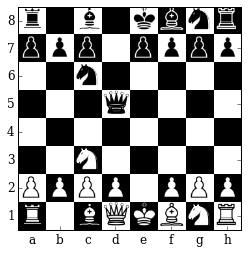

In [23]:
plt.xticks(range(8), string.lowercase)
ax = plt.imshow(draw_board(im), cmap = cm.binary_r)
ax.set_extent([-0.5,7.5,0.5,8.5])

In [24]:
def piece_prob_matrix(im, clipping=True):
    net.set_input_arrays(np.array([im], dtype='float32'),dummy)
    res = net.forward()
    probs = res['prob']
    if clipping:
        print "Probability matrix without clipping"
    else:
        print "Probability matrix before clipping"
        probs = clip_pieces_single_2(probs, im[0:12])
    matrix = probs.reshape((8,8))
    matrixplot(matrix)
def move_prob_matrix(im, piece_coords, clipping=True):
    net.set_input_arrays(np.array([im], dtype='float32'),dummy)
    res = net.forward()
    probs = res['prob']
    probs = probs.flatten()
    #probs = clip_pieces_single_2(probs, im[0:12])
    cumulative_probs = np.zeros((64,64))    
    for i, piece_pos in enumerate(topk(probs,10)):
        if probs[piece_pos]>0:
            i1,i2 = scoreToCoordinateIndex(piece_pos)
            pieceType = INDEX_TO_PIECE[np.argmax(im[0:12, i1, i2])/2]
            piece_layer = np.zeros((1,8,8))
            piece_layer[0,i1,i2] = 1
            img2 = np.append(im, piece_layer, axis=0)
            model = trained_models[pieceType]
            model.set_input_arrays(np.array([img2], dtype=np.float32),dummy)
            res2 = model.forward()
            move_prob = res2['prob']
            #print move_prob
            if clipping:
                move_prob = clip_moves_2(move_prob, img2[0:12], (i1,i2))
            #print move_prob
            cumulative_probs[piece_pos] = move_prob*probs[piece_pos]
    if clipping:
        print "Probability matrix after clipping"
    else:
        print "Probability matrix without clipping"
    matrixplot(cumulative_probs[piece_coords[0]*8+piece_coords[1]].reshape((8,8)))

In [25]:
def parseFEN(fen):
	""" Parses a string in Forsyth-Edwards Notation into a Position """
	board, color, castling, enpas, hclock, fclock = fen.split()
	board = re.sub('\d', (lambda m: '.'*int(m.group(0))), board)
	board = ' '*19+'\n ' + '\n '.join(board.split('/')) + ' \n'+' '*19
	wc = ('Q' in castling, 'K' in castling)
	bc = ('k' in castling, 'q' in castling)
	ep = sunfish.parse(enpas) if enpas != '-' else 0
	score = sum(sunfish.pst[p][i] for i,p in enumerate(board) if p.isupper())
	score -= sum(sunfish.pst[p.upper()][i] for i,p in enumerate(board) if p.islower())
	pos = sunfish.Position(board, score, wc, bc, ep, 0)
	return pos if color == 'w' else pos.rotate()
def posboard_to_im(pos):
    bb = pos_board_to_bitboard(pos)
    im = convert_bitboard_to_image_2(bb)
    im = np.rollaxis(im,2,0)
    im = np.append(im, elo_layer, axis=0)
    return im
def fen_to_im(fen):
    pos = parseFEN(fen)
    return posboard_to_im(pos.board)
def image_board(pos):
    plt.xticks(range(8), string.lowercase)
    ax = plt.imshow(draw_board(posboard_to_im(pos)), cmap=cm.Greys_r)
    f = plt.gcf()
    f.set_size_inches(6,6)
    ax.set_extent([-0.5,7.5,0.5,8.5])
    plt.show()

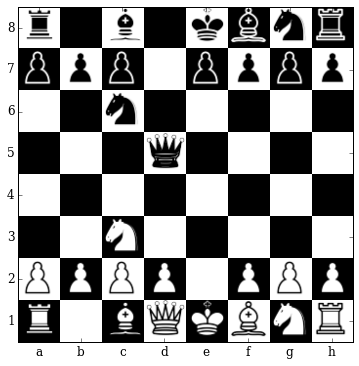

Probability matrix before clipping


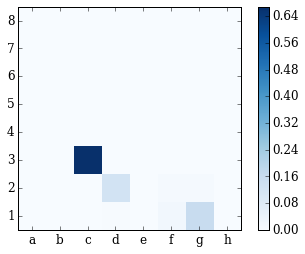

Probability matrix without clipping


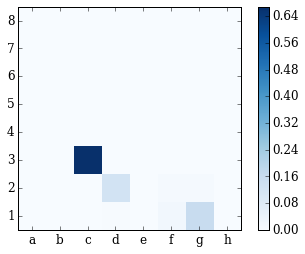

Probability matrix without clipping


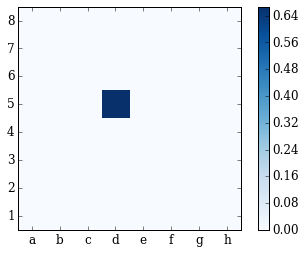

Probability matrix after clipping


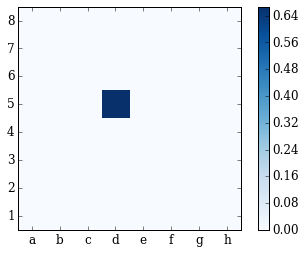

[('c3d5', 0.66716092824935913),
 ('g1f3', 0.1497281938791275),
 ('d2d4', 0.12208645790815353),
 ('f1c4', 0.011861790902912617),
 ('g1e2', 0.011521094478666782)]

In [26]:
fen = 'r1b1kbnr/ppp1pppp/2n5/3q4/8/2N5/PPPP1PPP/R1BQKBNR w KQkq - 0 4'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (5,2), False)
move_prob_matrix(im, (5,2))
get_top_moves(im, 5)

In [32]:
def piece_prob_matrix_2(im, clipping=True):
    net.set_input_arrays(np.array([im], dtype='float32'),dummy)
    res = net.forward()
    probs = res['prob']
    if clipping:
        print "Probability matrix without clipping"
    else:
        print "Probability matrix before clipping"
        probs = clip_pieces_single_2(probs, im[0:12])
    matrix = probs.reshape((8,8))
    return matrix

In [45]:
from prettytable import PrettyTable
x = PrettyTable()
for row in piece_prob_matrix_2(im, True):
    x.add_row(row)
print x.get_string(border=False)

Probability matrix without clipping
   Field 1      Field 2      Field 3      Field 4      Field 5      Field 6      Field 7      Field 8   
 2.84119e-08  8.52018e-08  2.01574e-08  4.18242e-06  7.08188e-08  4.35549e-09  3.28892e-09  2.98209e-09 
 4.33187e-08  3.57925e-07  5.24122e-09  3.72394e-06  1.92325e-08  1.63385e-06  9.61023e-07  1.75701e-07 
 5.67991e-08   1.7128e-08  8.77263e-10  1.27374e-07  1.33634e-07  2.65199e-07  5.63326e-07  4.95778e-07 
 1.57871e-07  1.18371e-08  3.54832e-09   4.1809e-10  9.03249e-09  5.96531e-08  8.84342e-09  7.48868e-08 
 5.84548e-09  8.00806e-09  2.01283e-08   6.5976e-09  3.44912e-10  8.07567e-10  4.75618e-09  8.62551e-10 
 7.33185e-09  5.32889e-09    0.669203   2.67841e-07  5.00018e-09  2.30968e-09  9.27975e-10  2.99387e-08 
  0.00179135  0.000149343   6.9688e-06    0.124215   4.78211e-08   0.00976956   0.00814895   0.00086575 
 0.000178495  6.93995e-08  1.46432e-05   0.0031704   9.72149e-05   0.0206326     0.161707   3.50478e-05 


In [48]:
for row in piece_prob_matrix_2(im, False):
    for x in row:
        print "%.7f \t"%x,
    print "\n"

Probability matrix before clipping
0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000001 	0.0000000 	0.0000000 	0.0000000 	

0.0000000 	0.0000004 	0.0000000 	0.0000000 	0.0000000 	0.0000016 	0.0000010 	0.0000002 	

0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	

0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	

0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	

0.0000000 	0.0000000 	0.6692101 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	

0.0017914 	0.0001493 	0.0000070 	0.1242167 	0.0000000 	0.0097697 	0.0081490 	0.0008658 	

0.0001785 	0.0000000 	0.0000146 	0.0031704 	0.0000972 	0.0206328 	0.1617092 	0.0000350 	



In [47]:
for row in piece_prob_matrix_2(im):
    for x in row:
        print "%.7f \t"%x,
    print "\n"

Probability matrix without clipping
0.0000000 	0.0000001 	0.0000000 	0.0000042 	0.0000001 	0.0000000 	0.0000000 	0.0000000 	

0.0000000 	0.0000004 	0.0000000 	0.0000037 	0.0000000 	0.0000016 	0.0000010 	0.0000002 	

0.0000001 	0.0000000 	0.0000000 	0.0000001 	0.0000001 	0.0000003 	0.0000006 	0.0000005 	

0.0000002 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000001 	0.0000000 	0.0000001 	

0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	

0.0000000 	0.0000000 	0.6692031 	0.0000003 	0.0000000 	0.0000000 	0.0000000 	0.0000000 	

0.0017913 	0.0001493 	0.0000070 	0.1242154 	0.0000000 	0.0097696 	0.0081490 	0.0008657 	

0.0001785 	0.0000001 	0.0000146 	0.0031704 	0.0000972 	0.0206326 	0.1617075 	0.0000350 	



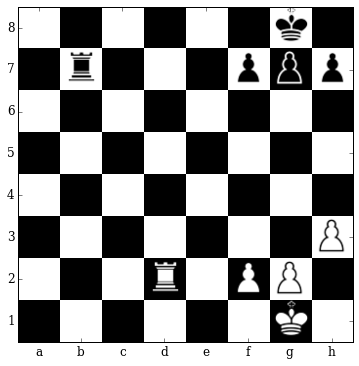

Probability matrix before clipping


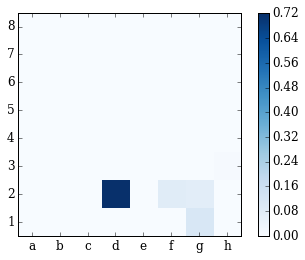

Probability matrix without clipping


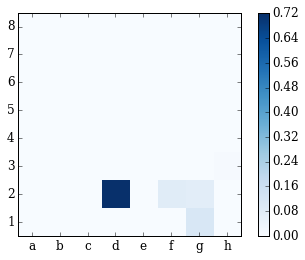

Probability matrix without clipping


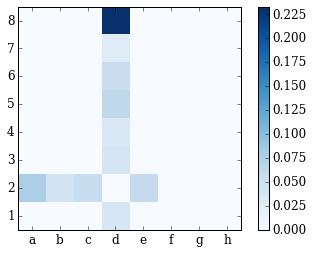

Probability matrix after clipping


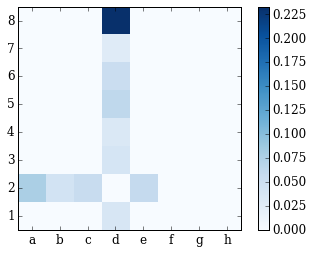

[('d2d8', 0.23323735594749451),
 ('g1h2', 0.0845494344830513),
 ('d2a2', 0.077860094606876373),
 ('d2d5', 0.062961988151073456),
 ('d2e2', 0.058588266372680664)]

In [26]:
fen = '6k1/1r3ppp/8/8/8/7P/3R1PP1/6K1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (6,3), False)
move_prob_matrix(im, (6,3))
get_top_moves(im, 5)

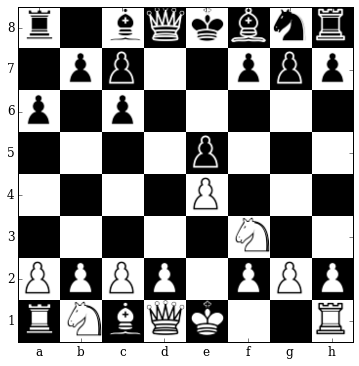

Probability matrix before clipping


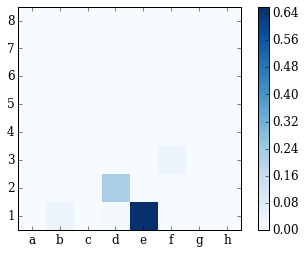

Probability matrix without clipping


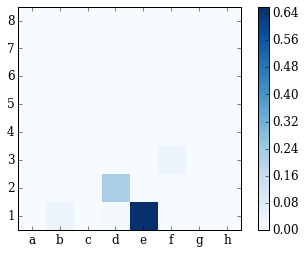

Probability matrix without clipping


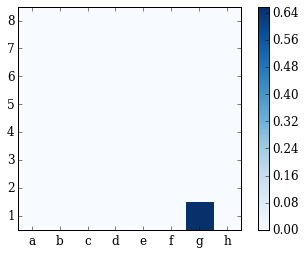

Probability matrix after clipping


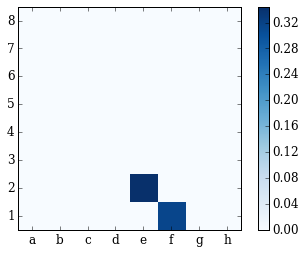

[('e1e2', 0.34457504749298096),
 ('e1f1', 0.31500616669654846),
 ('d2d4', 0.16115957498550415),
 ('d2d3', 0.062179621309041977),
 ('b1c3', 0.03972124308347702)]

In [27]:
'''
Castling :D 
Problem in clipping
'''
fen = 'r1bqkbnr/1pp2ppp/p1p5/4p3/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (7,4), False)
move_prob_matrix(im, (7,4))
get_top_moves(im, 5)

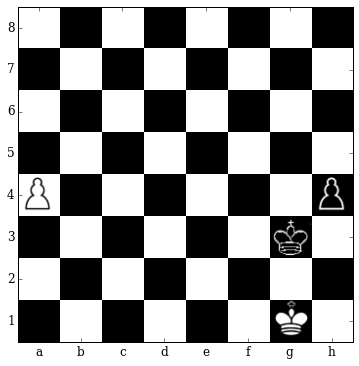

Probability matrix before clipping


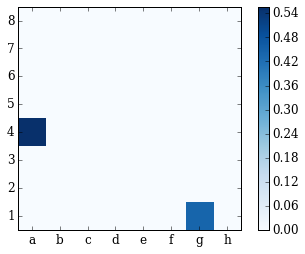

Probability matrix without clipping


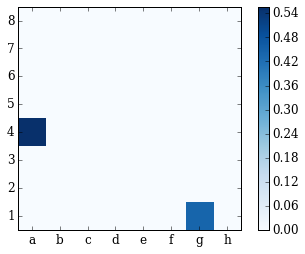

Probability matrix without clipping


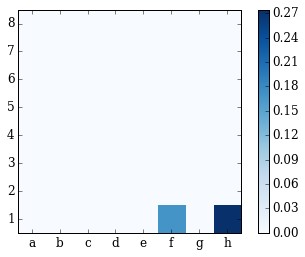

Probability matrix after clipping


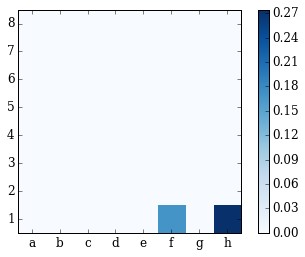

[('a4a5', 0.55695158243179321),
 ('g1h1', 0.27453842759132385),
 ('g1f1', 0.16850933432579041),
 ('f6g6', 0.0),
 ('f6d8', 0.0)]

In [28]:
fen = '8/8/8/8/P6p/6k1/8/6K1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (7,6), False)
move_prob_matrix(im, (7,6))
get_top_moves(im, 5)

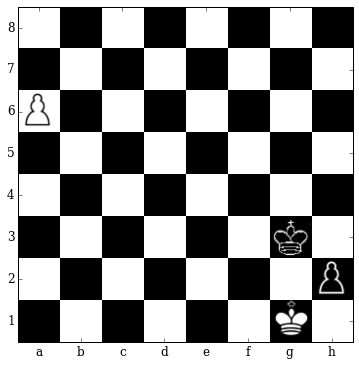

Probability matrix before clipping


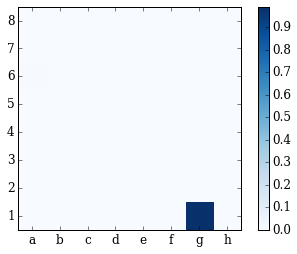

Probability matrix without clipping


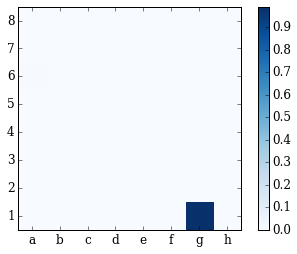

Probability matrix without clipping


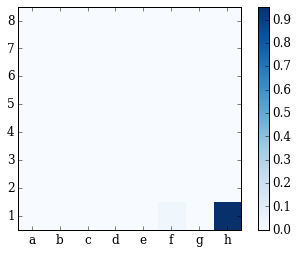

Probability matrix after clipping


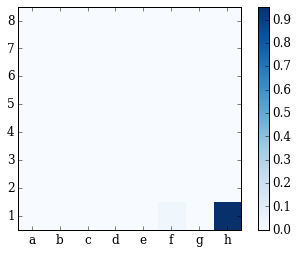

[('g1h1', 0.95602375268936157),
 ('g1f1', 0.036272428929805756),
 ('f6g6', 0.0),
 ('f6f6', 0.0),
 ('f6e6', 0.0)]

In [29]:
'''
Detecting a check and blocking a promotion
'''
fen = '8/8/P7/8/8/6k1/7p/6K1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (7,6), False)
move_prob_matrix(im, (7,6))
get_top_moves(im, 5)

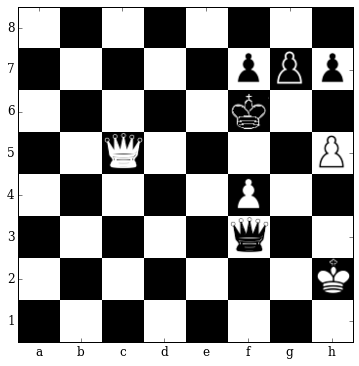

Probability matrix before clipping


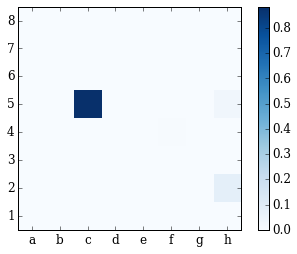

Probability matrix without clipping


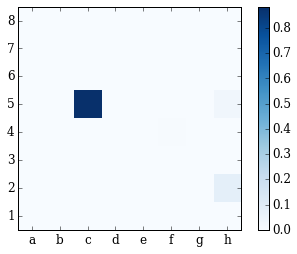

Probability matrix without clipping


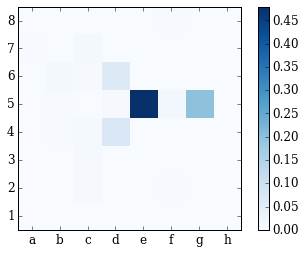

Probability matrix after clipping


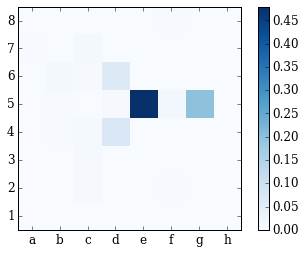

[('c5e5', 0.47968316078186035),
 ('c5g5', 0.19731871783733368),
 ('h2g1', 0.082665614783763885),
 ('c5d4', 0.069534681737422943),
 ('c5d6', 0.060287952423095703)]

In [30]:
'''
Mate in 1 ***
Cool example
'''
fen='8/5ppp/5k2/2Q4P/5P2/5q2/7K/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (3,2), False)
move_prob_matrix(im, (3,2))
get_top_moves(im, 5)

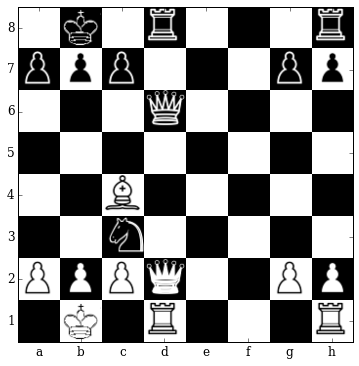

Probability matrix before clipping


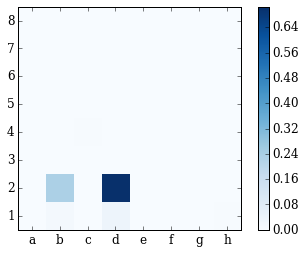

Probability matrix without clipping


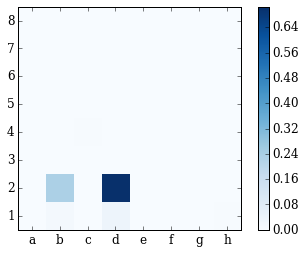

Probability matrix without clipping


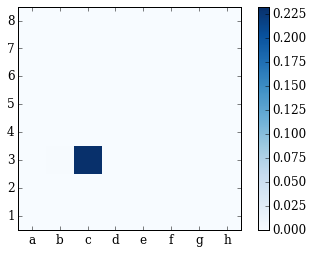

Probability matrix after clipping


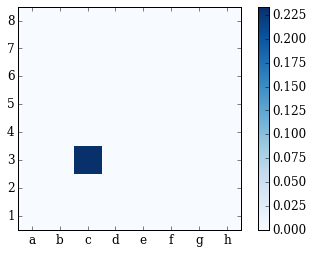

"\nA huge shock! \nBlack's knight is attacking my king and my rook on e8 - this is called a FORK (more on this later). \nAlso my queen on e7 is under attack twice (from White's queen and e1-rook). \nAlso, my back rank is weak! \nIf I capture the knight with my queen, White can play Qxe8 Rxe8 Rxe8 checkmate! \nAnd if I capture the knight with my pawn, he can play Qxe7 Rxe7 Rxe7. \nSo my only choice is to play...\n"

In [31]:
'''
Check
'''
fen='1k1r3r/ppp3pp/3q4/8/2B5/2n5/PPPQ2PP/1K1R3R w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (6,1), False)
move_prob_matrix(im, (6,1))
get_top_moves(im, 5)
'''
A huge shock! 
Black's knight is attacking my king and my rook on e8 - this is called a FORK (more on this later). 
Also my queen on e7 is under attack twice (from White's queen and e1-rook). 
Also, my back rank is weak! 
If I capture the knight with my queen, White can play Qxe8 Rxe8 Rxe8 checkmate! 
And if I capture the knight with my pawn, he can play Qxe7 Rxe7 Rxe7. 
So my only choice is to play...
'''


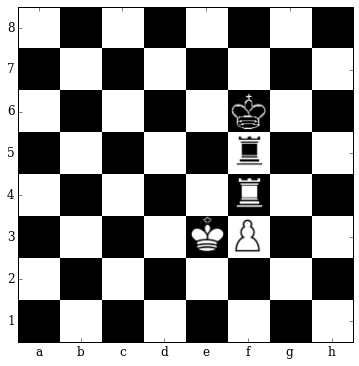

Probability matrix before clipping


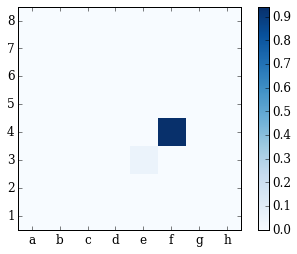

Probability matrix without clipping


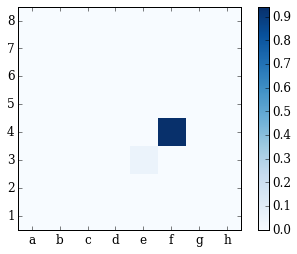

Probability matrix after clipping


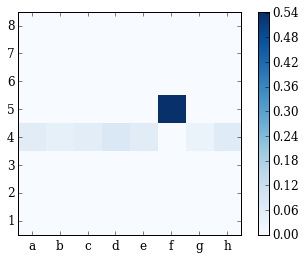

Probability matrix after clipping


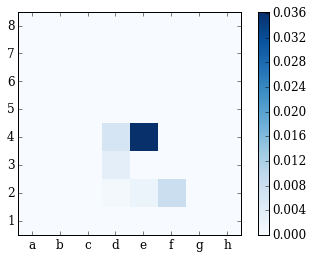

[('f4f5', 0.54274213314056396),
 ('f4d4', 0.07837030291557312),
 ('f4h4', 0.064125344157218933),
 ('f4e4', 0.060003038495779037),
 ('f4a4', 0.059576194733381271)]

In [32]:
'''
Trading rooks for endgame
White wants to trade rooks, but only on his terms!
'''
fen = '8/8/5k2/5r2/5R2/4KP2/8/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (4,5))
move_prob_matrix(im, (5,4))
get_top_moves(im, 5)

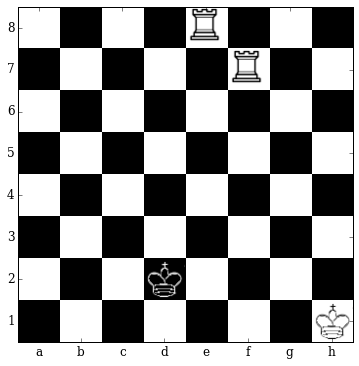

Probability matrix before clipping


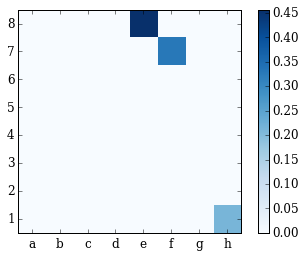

Probability matrix without clipping


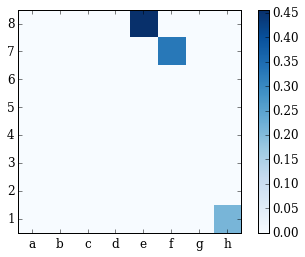

Probability matrix after clipping


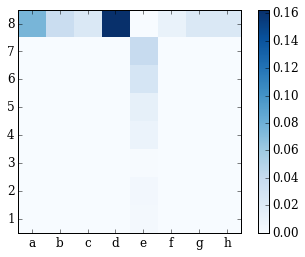

Probability matrix after clipping


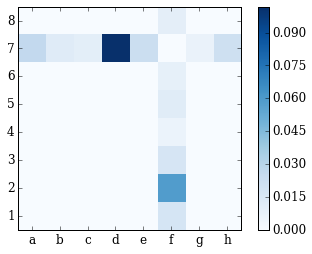

[('e8d8', 0.16258139908313751),
 ('f7d7', 0.10185147076845169),
 ('h1g1', 0.083854995667934418),
 ('e8a8', 0.076009191572666168),
 ('h1g2', 0.067719258368015289)]

In [33]:
'''
Pushing the broom
'''
fen='4R3/5R2/8/8/8/8/3k4/7K w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (0,4))
move_prob_matrix(im, (1,5))
get_top_moves(im, 5)

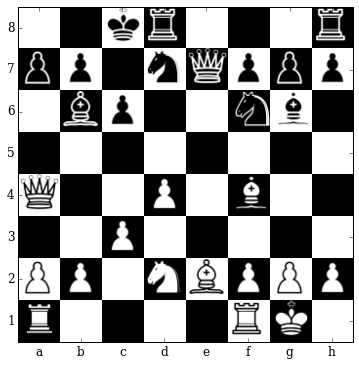

Probability matrix before clipping


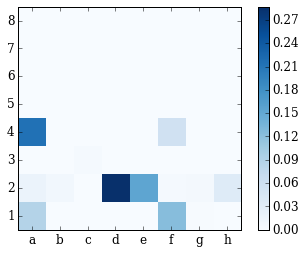

Probability matrix without clipping


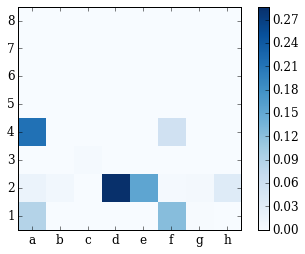

Probability matrix after clipping


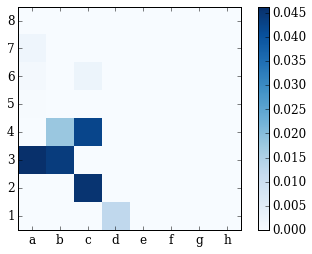

Probability matrix after clipping


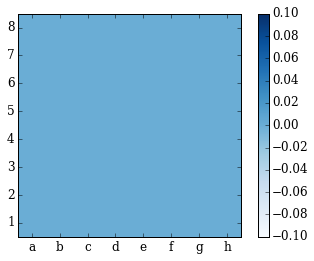

[('d2c4', 0.26504874229431152),
 ('f1e1', 0.10569902509450912),
 ('e2f3', 0.10499047487974167),
 ('a1e1', 0.061389181762933731),
 ('a4a3', 0.046335931867361069)]

In [34]:
fen='2kr3r/pp1nqppp/1bp2nb1/8/Q2P1B2/2P5/PP1NBPPP/R4RK1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (4,0))
move_prob_matrix(im, (1,5))
get_top_moves(im, 5)

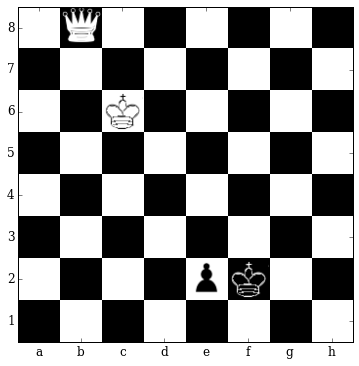

Probability matrix before clipping


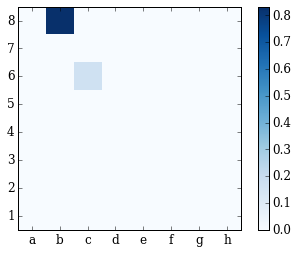

Probability matrix without clipping


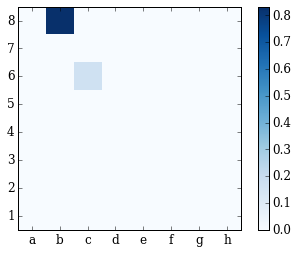

Probability matrix after clipping


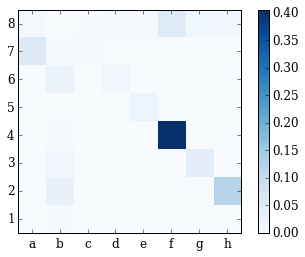

Probability matrix after clipping


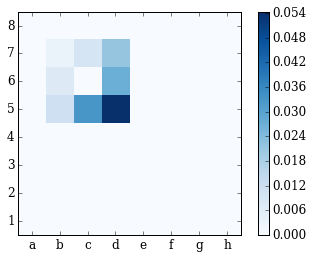

'\nQf4+ gets the Queen close to the enemy King and \nstops the Black pawn from Queening but giving a check.\n'

In [35]:
'''
Queen King vs King Pawn
'''
fen = '1Q6/8/2K5/8/8/8/4pk2/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (0,1))
move_prob_matrix(im, (2,2))
get_top_moves(im, 5)
'''
Qf4+ gets the Queen close to the enemy King and 
stops the Black pawn from Queening but giving a check.
'''

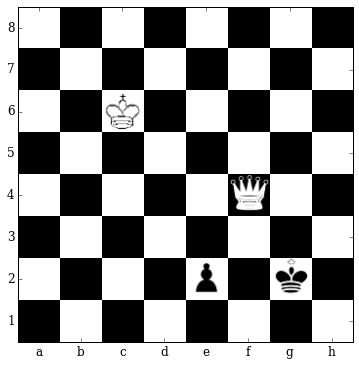

Probability matrix before clipping


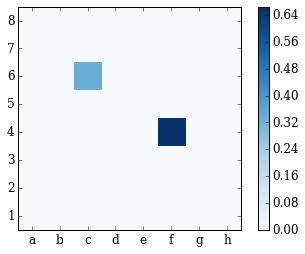

Probability matrix without clipping


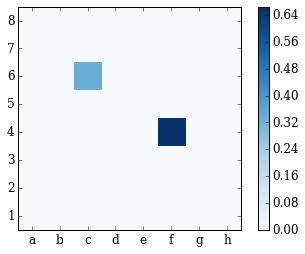

Probability matrix after clipping


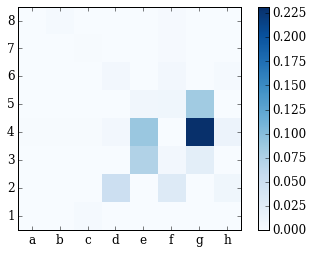

Probability matrix after clipping


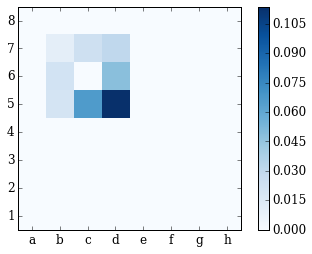

[('f4g4', 0.23201958835124969),
 ('c6d5', 0.11371637880802155),
 ('f4e4', 0.089005529880523682),
 ('f4g5', 0.084662489593029022),
 ('f4e3', 0.073308832943439484)]

In [36]:
'''
Continued from above
'''
fen = '8/8/2K5/8/5Q2/8/4p1k1/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (4,5))
move_prob_matrix(im, (2,2))
get_top_moves(im, 5)

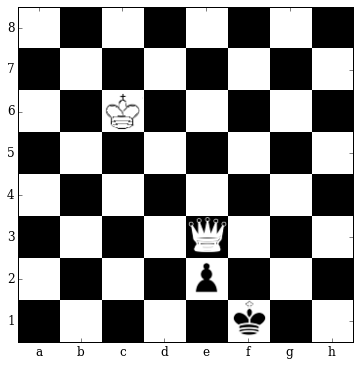

Probability matrix before clipping


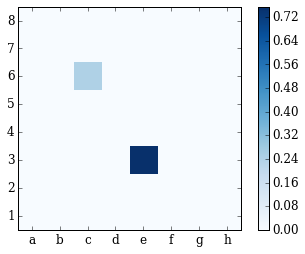

Probability matrix without clipping


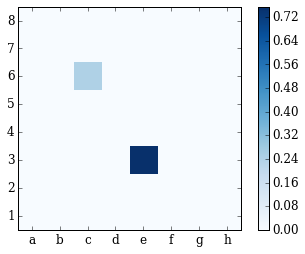

Probability matrix after clipping


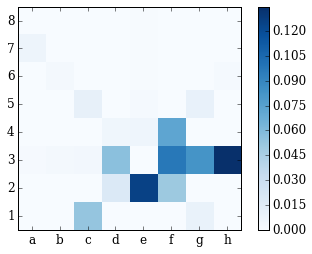

Probability matrix after clipping


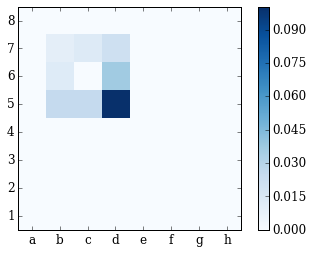

[('e3h3', 0.13469482958316803),
 ('e3e2', 0.12544131278991699),
 ('c6d5', 0.10035960376262665),
 ('e3f3', 0.0969805046916008),
 ('e3g3', 0.082934893667697906)]

In [37]:
fen='8/8/2K5/8/8/4Q3/4p3/5k2 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (5,4))
move_prob_matrix(im, (2,2))
get_top_moves(im, 5)

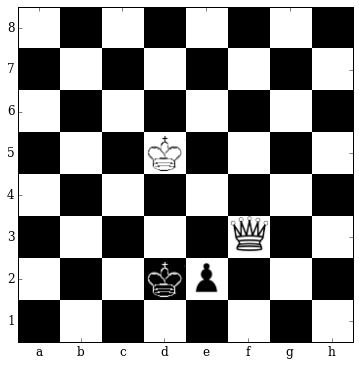

Probability matrix before clipping


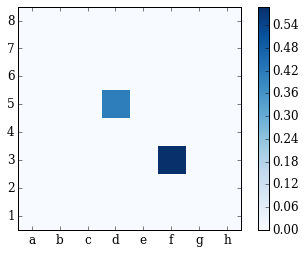

Probability matrix without clipping


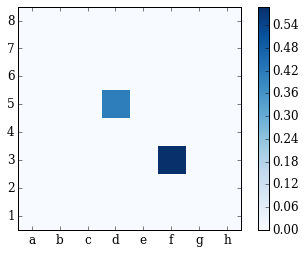

Probability matrix after clipping


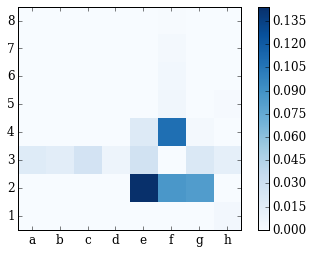

Probability matrix after clipping


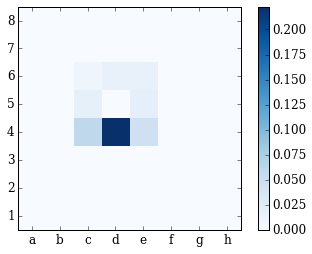

[('d5d4', 0.2228522002696991),
 ('f3e2', 0.14431160688400269),
 ('f3f4', 0.10917683690786362),
 ('f3f2', 0.086296409368515015),
 ('f3g2', 0.082867786288261414)]

In [38]:
fen='8/8/8/3K4/8/5Q2/3kp3/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (5,5))
move_prob_matrix(im, (3,3))
get_top_moves(im, 5)

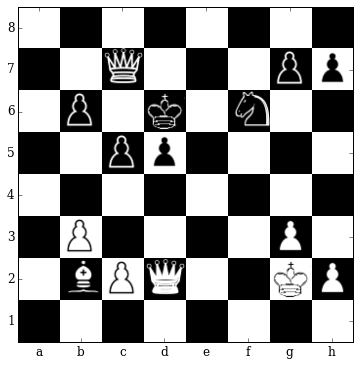

Probability matrix before clipping


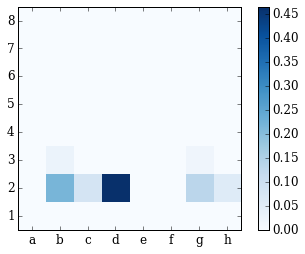

Probability matrix without clipping


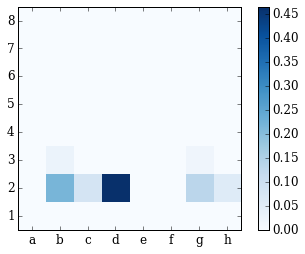

Probability matrix after clipping


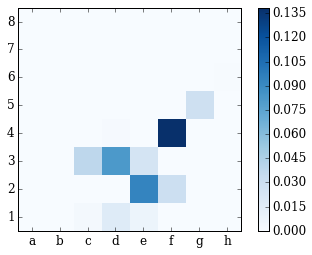

Probability matrix after clipping


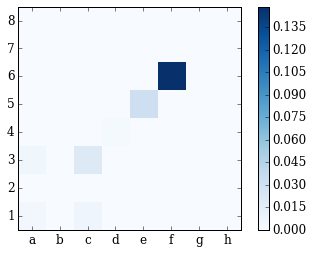

[('b2f6', 0.148805171251297),
 ('d2f4', 0.13850629329681396),
 ('d2e2', 0.093351386487483978),
 ('d2d3', 0.081881873309612274),
 ('c2c4', 0.067699603736400604)]

In [39]:
fen='8/2q3pp/1p1k1n2/2pp4/8/1P4P1/1BPQ2KP/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (6,3))
move_prob_matrix(im, (6,1))
get_top_moves(im, 5)

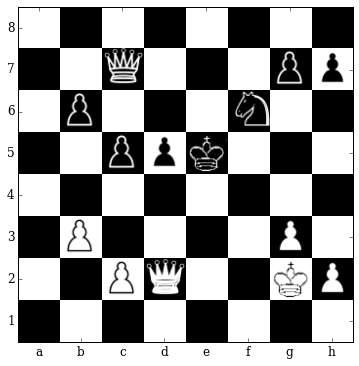

Probability matrix before clipping


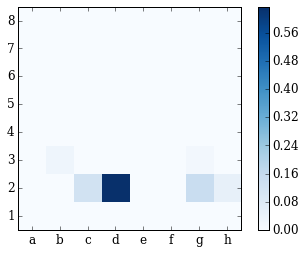

Probability matrix without clipping


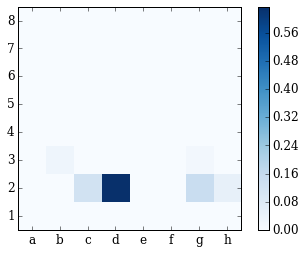

Probability matrix after clipping


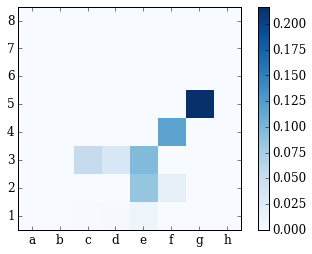

Probability matrix after clipping


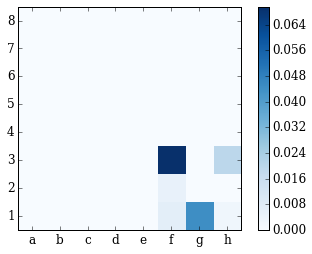

[('d2g5', 0.21698001027107239),
 ('d2f4', 0.11807477474212646),
 ('d2e3', 0.096141017973423004),
 ('d2e2', 0.085893034934997559),
 ('g2f3', 0.069620192050933838)]

In [40]:
fen='8/2q3pp/1p3n2/2ppk3/8/1P4P1/2PQ2KP/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (6,3))
move_prob_matrix(im, (6,6))
get_top_moves(im, 5)

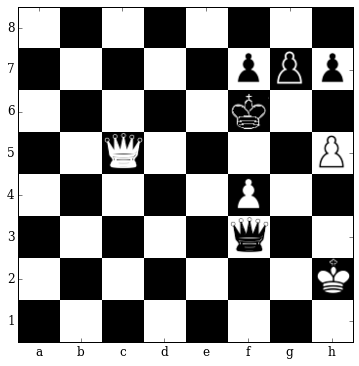

Probability matrix before clipping


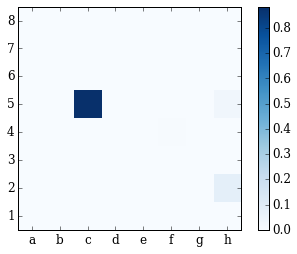

Probability matrix without clipping


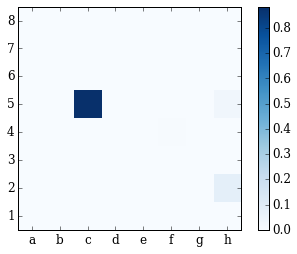

Probability matrix after clipping


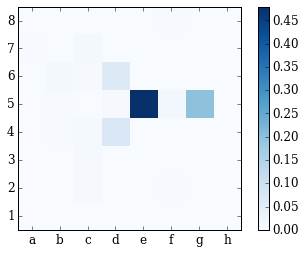

Probability matrix after clipping


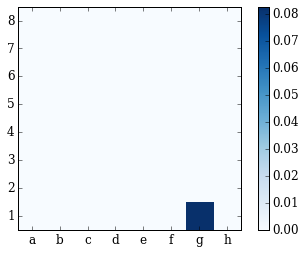

[('c5e5', 0.47968316078186035),
 ('c5g5', 0.19731871783733368),
 ('h2g1', 0.082665614783763885),
 ('c5d4', 0.069534681737422943),
 ('c5d6', 0.060287952423095703)]

In [41]:
'''Checkmate in 1'''
fen='8/5ppp/5k2/2Q4P/5P2/5q2/7K/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (3,2))
move_prob_matrix(im, (6,7))
get_top_moves(im, 5)

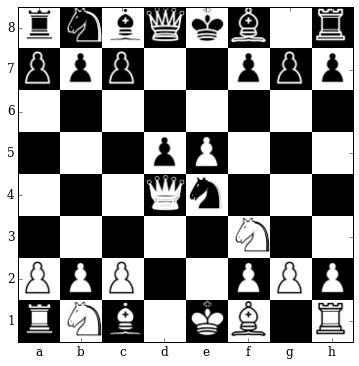

Probability matrix before clipping


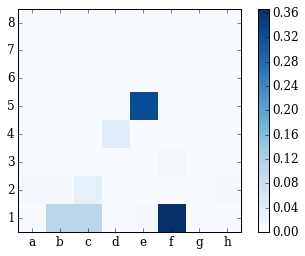

Probability matrix without clipping


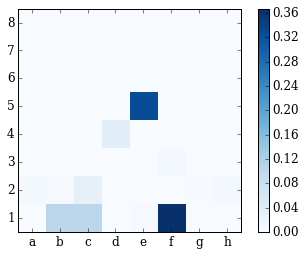

Probability matrix without clipping


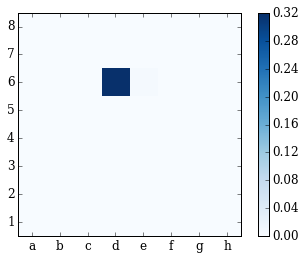

Probability matrix without clipping


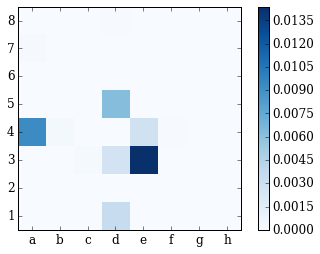

[('e5e6', 0.32594642043113708),
 ('f1d3', 0.32424727082252502),
 ('b1c3', 0.089611709117889404),
 ('c1e3', 0.074527129530906677),
 ('f1b5', 0.029854923486709595)]

In [44]:
'''En Passant'''
fen = 'rnbqkb1r/ppp2ppp/8/3pP3/3Qn3/5N2/PPP2PPP/RNB1KB1R w KQkq - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (3,4), False)
move_prob_matrix(im, (4,3), False)
get_top_moves(im, 5)

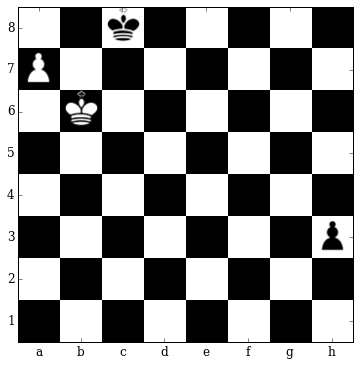

Probability matrix before clipping


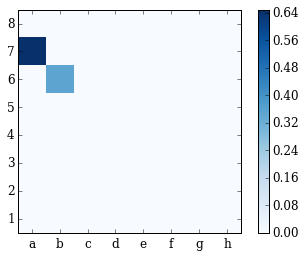

Probability matrix without clipping


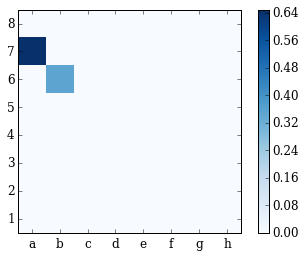

Probability matrix without clipping


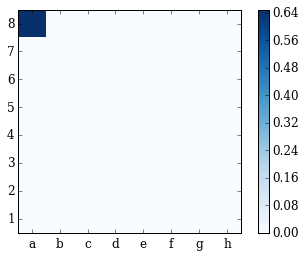

Probability matrix without clipping


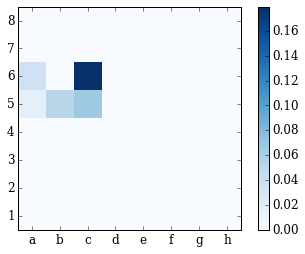

[('b6c6', 0.17956133186817169),
 ('b6c5', 0.067257583141326904),
 ('b6b5', 0.051960546523332596),
 ('b6a6', 0.035805638879537582),
 ('b6a5', 0.015805186703801155)]

In [46]:
'''
promotion
'''
fen = '2k5/P7/1K6/8/8/7p/8/8 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
piece_prob_matrix(im)
move_prob_matrix(im, (1,0), False)
move_prob_matrix(im, (2,1), False)
get_top_moves(im, 5)

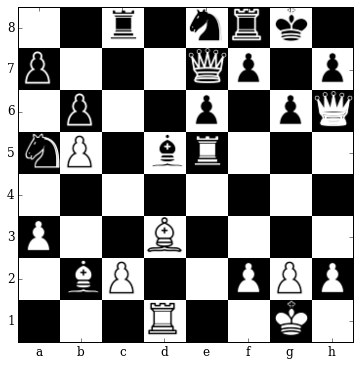

Probability matrix before clipping


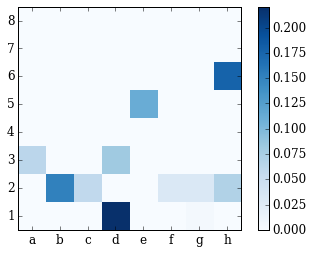

[('d1e1', 0.1757311075925827),
 ('b2d4', 0.09299052506685257),
 ('a3a4', 0.062875278294086456),
 ('c2c4', 0.057595331221818924),
 ('h6f4', 0.053821366280317307),
 ('h6e3', 0.050146892666816711),
 ('e5g5', 0.03972143679857254),
 ('d3f1', 0.036402236670255661),
 ('h2h4', 0.03613227978348732),
 ('h2h3', 0.033109508454799652),
 ('b2c3', 0.032773066312074661),
 ('e5e1', 0.030211877077817917),
 ('g2g3', 0.029032109305262566),
 ('f2f4', 0.023405348882079124),
 ('h6g5', 0.02339525893330574),
 ('e5e3', 0.019956132397055626),
 ('h6h3', 0.019858075305819511),
 ('d1f1', 0.018210195004940033),
 ('d3e4', 0.01796974241733551),
 ('b2c1', 0.015060528181493282),
 ('d3e2', 0.014883079566061497),
 ('e5e2', 0.014404367655515671),
 ('h6d2', 0.013167580589652061),
 ('h6h4', 0.0122352484613657),
 ('b2a1', 0.010595557279884815),
 ('d3g6', 0.010304092429578304),
 ('d1c1', 0.0091396737843751907),
 ('f2f3', 0.0078698936849832535),
 ('d1d2', 0.0064849811606109142),
 ('d1b1', 0.0062614143826067448),
 ('d1a1', 0.004

In [53]:
'''checkmate in 3 for white'''
fen = '2r1nrk1/p3qp1p/1p2p1pQ/nP1bR3/8/P2B4/1BP2PPP/3R2K1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
get_top_moves(im,40)

In [54]:
pos = parseFEN('2r1nrk1/p3qp1p/1p2p1pQ/nP1bR3/8/P2B4/1BP2PPP/3R2K1 w - - 0 0')

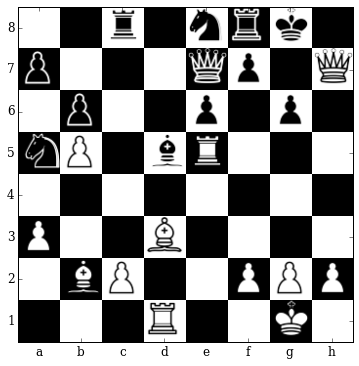

ValueError: could not broadcast input array from shape (13,8) into shape (8,8)

In [62]:
image_board(pos.move((sunfish.parse('h6'), sunfish.parse('h7'))).rotate().board)
im = posboard_to_im(pos.move((sunfish.parse('h6'), sunfish.parse('h7'))).board)
im = flip_color_2(im)
piece_prob_matrix(im, False)
get_top_moves(im,40)

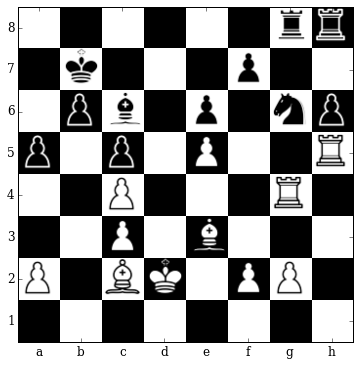

In [46]:
fen = '6rr/1k3p2/1pb1p1np/p1p1P2R/2P3R1/2P1B3/P1BK1PP1/8 w - - 0 0'
pos = parseFEN(fen)
bb = pos_board_to_bitboard(pos.board)
im = convert_bitboard_to_image_2(bb)
im = flip_color_2(im)
im = flip_image(im)
im = np.rollaxis(im, 2, 0)
im = np.append(im, elo_layer, axis=0)
image_board(pos.board)

In [56]:
moves = get_top_moves(im, 20)

Probability matrix before clipping


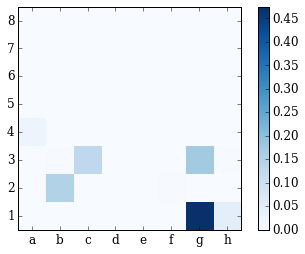

Probability matrix after clipping


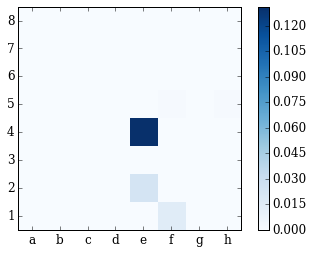

Probability matrix after clipping


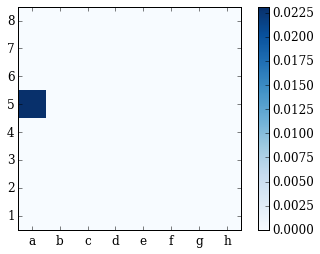

In [53]:
piece_prob_matrix(im, False)
move_prob_matrix(im, (5,6))
move_prob_matrix(im, (4,0))

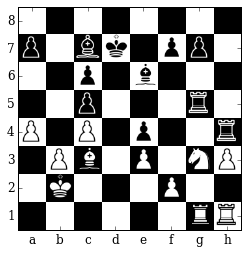

In [47]:
plt.xticks(range(8), string.lowercase)
ax = plt.imshow(draw_board(im), cmap = cm.binary_r)
ax.set_extent([-0.5,7.5,0.5,8.5])

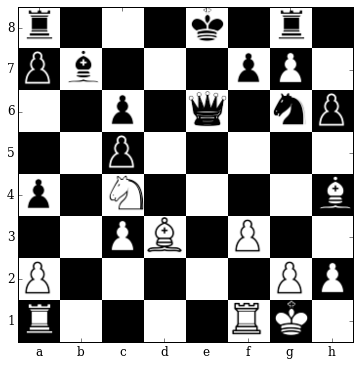

Probability matrix before clipping


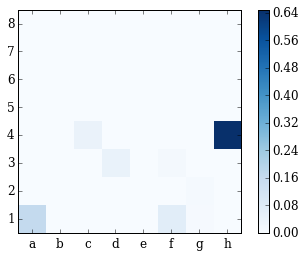

[('h4f2', 0.32933327555656433),
 ('h4g3', 0.2398655116558075),
 ('a1e1', 0.11561619490385056),
 ('f1e1', 0.056696739047765732),
 ('h4f6', 0.048246525228023529),
 ('h4e1', 0.031455948948860168),
 ('d3g6', 0.030796339735388756),
 ('a1b1', 0.030671844258904457),
 ('c4d6', 0.019964069128036499),
 ('a1d1', 0.017095580697059631),
 ('f3f4', 0.011587467044591904),
 ('c4e3', 0.0084877870976924896),
 ('c4a5', 0.0083616171032190323),
 ('d3f5', 0.0082327639684081078),
 ('g2g3', 0.0062277684919536114),
 ('f1d1', 0.0056227818131446838),
 ('g1h1', 0.0050440151244401932),
 ('f1b1', 0.0043563172221183777),
 ('d3c2', 0.0029176215175539255),
 ('f1f2', 0.0025211658794432878),
 ('a1c1', 0.0024774004705250263),
 ('g1f2', 0.0019911518320441246),
 ('a2a3', 0.0019263502908870578),
 ('d3e4', 0.0017436948837712407),
 ('g2g4', 0.0016631180187687278),
 ('c4e5', 0.0012814141809940338),
 ('h2h3', 0.0011610848596319556),
 ('c4b2', 0.00097782746888697147),
 ('c4a3', 0.00070255022728815675),
 ('c4d2', 0.000616493460256

In [44]:
fen = 'r3k1r1/pb3pP1/2p1q1np/2p5/p1N4B/2PB1P2/P5PP/R4RK1 w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
get_top_moves(im,40)

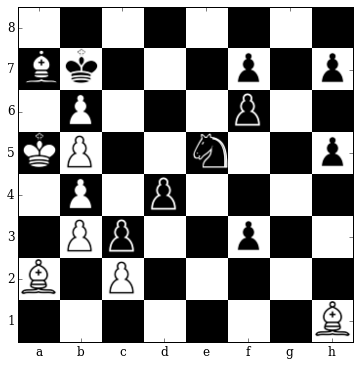

Probability matrix before clipping


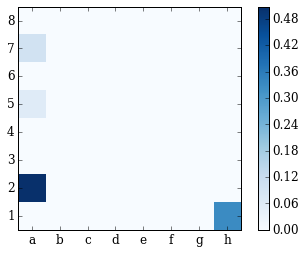

[('a2b1', 0.50829505920410156),
 ('h1f3', 0.328020840883255),
 ('a7b8', 0.096098668873310089),
 ('a5a4', 0.060861673206090927),
 ('h1g2', 0.0020993500947952271),
 ('a5a6', 0.00040940550388768315),
 ('f6h7', 0.0),
 ('f6g5', 0.0),
 ('f6c6', 0.0),
 ('f6d6', 0.0),
 ('f6e6', 0.0),
 ('f6f6', 0.0),
 ('f6g6', 0.0),
 ('f6h6', 0.0),
 ('f6a5', 0.0),
 ('f6b5', 0.0),
 ('f6c5', 0.0),
 ('f6d5', 0.0),
 ('f6e5', 0.0),
 ('f6f5', 0.0)]

In [45]:
fen = '8/Bk3p1p/1P3p2/KP2n2p/1P1p4/1Pp2p2/B1P5/7B w - - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
get_top_moves(im,20)

In [55]:
coord2d_to_chess_coord(flip_coord2d(chess_coord_to_coord2d('h1')))

'h8'

In [58]:
for move,val in moves:
    print coord2d_to_chess_coord(flip_coord2d(chess_coord_to_coord2d(move[0:2])))\
    +coord2d_to_chess_coord(flip_coord2d(chess_coord_to_coord2d(move[2:4]))),\
    val

g8d8 0.252880722284
g8g7 0.148237019777
g6e5 0.13111974299
b7c7 0.0660261586308
h8h7 0.0471959412098
c6g2 0.0403394699097
c6e8 0.0358173549175
g8c8 0.0323895104229
b7c8 0.0302288047969
c6d7 0.0250529013574
a5a4 0.0231475103647
g6e7 0.0229441132396
b7a6 0.0208601523191
g8a8 0.0198916308582
b7b8 0.0190593209118
c6a4 0.0153007712215
g6f8 0.0150824002922
g8f8 0.0115283448249
g8e8 0.00727259740233
b7a7 0.00666899653152


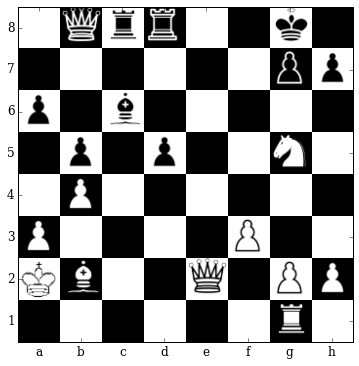

[('e2e6', 0.24401834607124329),
 ('g5e6', 0.16207633912563324),
 ('g1c1', 0.093031316995620728),
 ('e2e7', 0.082513898611068726),
 ('b2e5', 0.055714938789606094)]

In [65]:
"""http://cognition.uni-klu.ac.at/chess/einstellung.htm"""
fen = '1qrr2k1/6pp/p1b5/1p1p2N1/1P6/P4P2/KB2Q1PP/6R1 w - - 0 0'
image_board(parseFEN(fen).board)
im = fen_to_im(fen)
get_top_moves(im, 5)

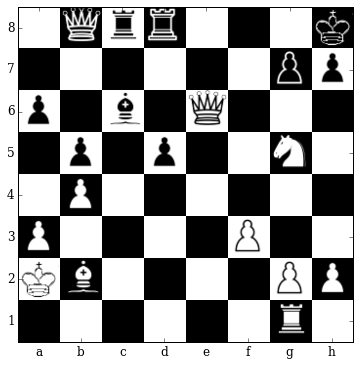

[('g5f7', 0.26569965481758118),
 ('e6f7', 0.14253579080104828),
 ('g1c1', 0.11660485714673996),
 ('f3f4', 0.082100778818130493),
 ('e6f5', 0.061043418943881989)]

In [66]:
"""Contd"""
fen = '1qrr3k/6pp/p1b1Q3/1p1p2N1/1P6/P4P2/KB4PP/6R1 w - - 0 0'
image_board(parseFEN(fen).board)
im = fen_to_im(fen)
get_top_moves(im, 5)

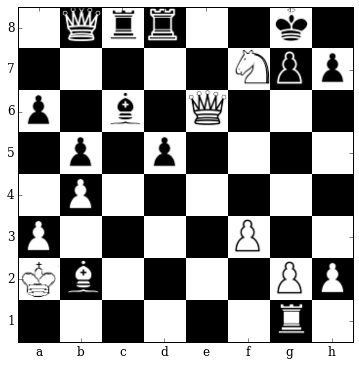

[('f7d8', 0.61297577619552612),
 ('e6e7', 0.050408937036991119),
 ('g1c1', 0.050186410546302795),
 ('g1e1', 0.037320245057344437),
 ('f7e5', 0.036927882581949234),
 ('b2e5', 0.036734938621520996),
 ('e6g4', 0.025703873485326767),
 ('e6f5', 0.025326257571578026),
 ('f7h6', 0.021580841392278671),
 ('f3f4', 0.020423173904418945)]

In [68]:
"""Contd"""
fen = '1qrr2k1/5Npp/p1b1Q3/1p1p4/1P6/P4P2/KB4PP/6R1 w - - 0 0'
image_board(parseFEN(fen).board)
im = fen_to_im(fen)
get_top_moves(im,10)

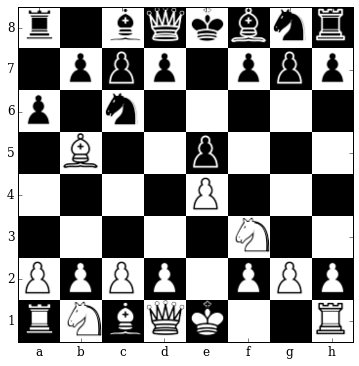

Probability matrix before clipping


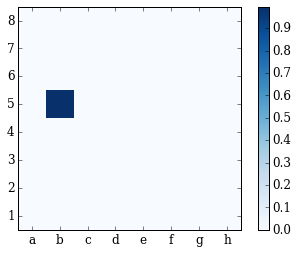

Probability matrix without clipping


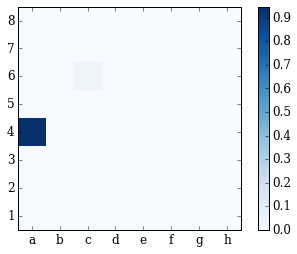

[('b5a4', 0.94735425710678101),
 ('b5c6', 0.046515405178070068),
 ('b5c4', 0.001301472308114171),
 ('e1f1', 0.0011871048482134938),
 ('b5f1', 0.0011764399241656065),
 ('d2d4', 0.00072513130726292729),
 ('e1e2', 0.00057429383741691709),
 ('b5e2', 0.00051104387966915965),
 ('b1c3', 0.00017992433276958764),
 ('c2c4', 0.00012611925194505602),
 ('f3e5', 7.8958692029118538e-05),
 ('c2c3', 6.316589133348316e-05),
 ('d2d3', 6.1958584410604089e-05),
 ('d1e2', 4.1619980038376525e-05),
 ('b5d3', 3.3970783988479525e-05),
 ('b2b3', 1.9307821276015602e-05),
 ('f3g5', 1.5385843653348275e-05),
 ('a2a4', 1.2117193364247214e-05),
 ('h2h3', 7.6468886618386023e-06),
 ('b5a6', 4.3499685489223339e-06)]

In [70]:
fen = 'r1bqkbnr/1ppp1ppp/p1n5/1B2p3/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 0'
im = fen_to_im(fen)
image_board(parseFEN(fen).board)
piece_prob_matrix(im, False)
move_prob_matrix(im, (3,1), False )
get_top_moves(im,20)

In [22]:
import h5py as h5
ebd_x = h5.File("/data/ConvChess/data/CvC_data_multi_elolayer_piecelayer_h5/X_117500_120000.h5")
x_ = np.asarray(ebd_x['data'])
y_ = np.asarray(ebd_x['label'])
print x_.shape, y_.shape

(299066, 13, 8, 8) (299066,)


In [23]:
piece_net = trained_models['Piece']
piece_net.set_input_arrays(x_, y_)

In [41]:
tsne_x = []
piece_types = []
plabels = []
for x in x_:
    piece_net.forward()
    tsne_x.append(np.asfarray( piece_net.blobs['fc1'].data.flatten(), dtype='float'))
    pred_label =  piece_net.blobs['plabel'].data.flatten()
    plabels.append(int(pred_label))
    pred_label_2d = (int(pred_label)/8, int(pred_label)%8)
    which_layer = np.where(piece_net.blobs['data'].data[0,:,pred_label_2d[0], pred_label_2d[1]]==1)
    piece_types.append(INDEX_TO_PIECE[int(which_layer[0])/2])
    

KeyboardInterrupt: 

In [42]:
tsne_x = np.asfarray(tsne_x, dtype='float')
print tsne_x.shape

(5055, 64)


In [26]:
tsne_x = np.reshape(tsne_x, (tsne_x.shape[0],tsne_x.shape[2]))

IndexError: tuple index out of range

In [27]:
tsne_x = tsne_x[0:5000]
piece_types_2 = [PIECE_TO_INDEX[ptype] for ptype in piece_types]


In [43]:
from time import time
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap, TSNE
print "Number of points:",len(tsne_x)
print "TSNE running"
t0 = time()
Y1 = TSNE(verbose=1, n_iter=1000, early_exaggeration=10.0, learning_rate=200).fit_transform(tsne_x)
t1 = time()
print("TSNE took %.2g sec" % (t1 - t0))
#colors = cm.rainbow(np.linspace(0, 1, 64))
for i in xrange(Y1.shape[0]):
    plt.scatter(Y1[i,0],Y1[i,1], color= colors2[plabels[i]])# color= colors[piece_types[i]])
#plt.legend()
plt.show()
# import cPickle as pkl
# pkl.dump(Y1, open("tsne_piece.pkl","w"))

Number of points: 5055
TSNE running
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 5055
[t-SNE] Computed conditional probabilities for sample 2000 / 5055
[t-SNE] Computed conditional probabilities for sample 3000 / 5055
[t-SNE] Computed conditional probabilities for sample 4000 / 5055
[t-SNE] Computed conditional probabilities for sample 5000 / 5055
[t-SNE] Computed conditional probabilities for sample 5055 / 5055
[t-SNE] Mean sigma: 7.882718
[t-SNE] Error after 86 iterations with early exaggeration: 74.318022
[t-SNE] Error after 330 iterations: 3.789198
TSNE took 7e+02 sec


In [83]:
np.where(piece_net.blobs['data'].data[0,:,]==1)

(array([ 0,  6, 10, 11]), array([1, 5, 3, 0]), array([0, 4, 3, 0]))

In [101]:
true_label = piece_net.blobs['label'].data.flatten()

true_label_2d = (int(true_label)/8, int(true_label)%8)
pred_label =  piece_net.blobs['plabel'].data.flatten()
pred_label_2d = (int(pred_label)/8, int(pred_label)%8)
which_layer = np.where(piece_net.blobs['data'].data[0,:,pred_label_2d[0], pred_label_2d[1]]==1)
print  INDEX_TO_PIECE[int(which_layer[0])/2]

3

In [47]:
colors1 = {'P':'k', 'R':'r', 'N':'y', 'K':'m', 'Q':'b', 'B':'g'}

In [33]:
colors2 = cm.Blues(np.linspace(0, 1, 64))

In [124]:
piece_net.blobs['conv1'].data.flatten().shape

(6144,)

In [99]:
from util import *

In [64]:
%matplotlib qt
for i in xrange(Y1.shape[0]):
    plt.scatter(Y1[i,0],Y1[i,1], color= colors1[piece_types[i]])
#plt.legend()
plt.show()


In [130]:
piece_net.blobs.keys()

['data',
 'label',
 'conv1',
 'conv2',
 'conv3',
 'fc1',
 'fc1_fc1_0_split_0',
 'fc1_fc1_0_split_1',
 'prob',
 'plabel']

In [60]:
piece_types_2 = np.reshape([PIECE_TO_INDEX[ptype] for ptype in piece_types],( len(piece_types), ))

In [63]:
piece_types_2

array([2, 3, 1, ..., 1, 4, 4])

In [65]:
prob

NameError: name 'prob' is not defined